# Применение моделей ARMA и GARCH для прогнозирования доходности и волатильности акций компании Philip Morris 


In [ ]:
!pip install yfinance
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt

import statsmodels as sm 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Выгрузка данных для трейнинг выборки. 

Берется промежуток 01.01.2018 - 31.12.2020 для построения модели ARMA. 

Далее для проведения out-of-sample проверки будет взята тестовая выборка: 01.01.2021 - 12.31.2021

In [ ]:
df_1 = yf.download('PM', start = '2018-01-01', end = '2020-12-31')['Adj Close']
df_2 = pd.DataFrame(df_1)
df_2

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2018-01-02 00:00:00-05:00,79.951584
2018-01-03 00:00:00-05:00,79.852036
2018-01-04 00:00:00-05:00,79.246979
2018-01-05 00:00:00-05:00,79.882675
2018-01-08 00:00:00-05:00,79.760132
...,...
2020-12-23 00:00:00-05:00,75.028091
2020-12-24 00:00:00-05:00,75.311050
2020-12-28 00:00:00-05:00,75.292786


Подсчет лог доходностей акций и построение графика их динамики. 

По графику ниже видно, что доходности харатктериуются кластеризацией: ввделяются кластеры с высокими и средними показателями волатильности, что характерно для финансовых данных.

Заметны достаточно сильные отклонения в середине 2018 года, 2019 и 2020 годах

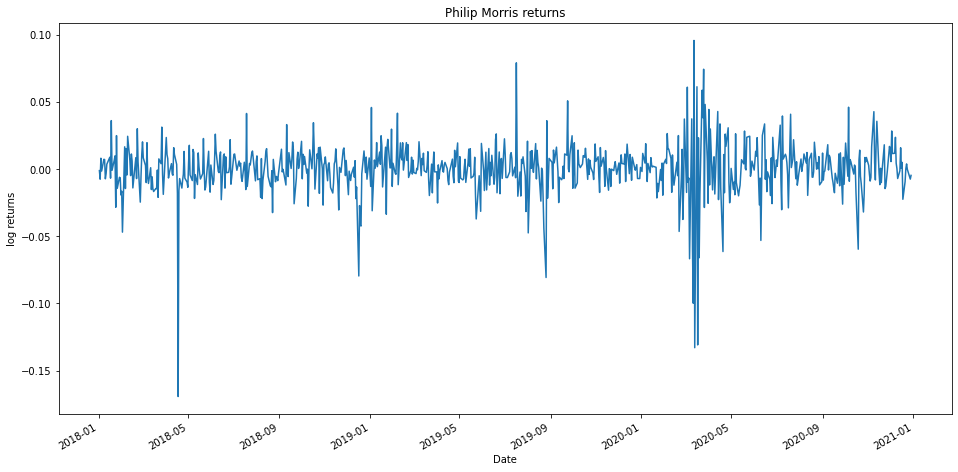

In [ ]:
df_2['log_rtns'] = np.log(df_2.shift(-1)/df_2)
df_2.dropna(inplace = True)
df_2['log_rtns'].plot(figsize=(16,8))
plt.ylabel('log returns')
plt.title ('Philip Morris returns')
plt.show()


График реального изменения цен подтверждает выводы о высокой волатильности актива, сделанные ранее

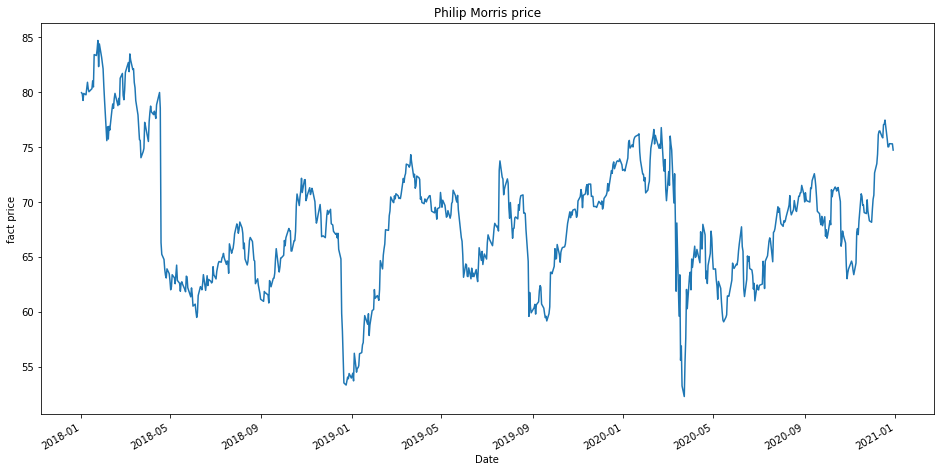

In [ ]:
df_2['Adj Close'].plot(figsize=(16,8))
plt.ylabel('fact price')
plt.title ('Philip Morris price')
plt.show()

Перед построением модели необходимо оценить коррелограммы автокорреляции и частичной автокорреляции. 

По диаграмме автокорреляции видно, что временные данные доходностей имеют отрицательную зависимость от предыдущих значений. Значимая корреляция заканчивается на 11 лаге. В данных отсутствует выраженный тренд. 

График частичной автокорреляции показывает схожую картинку. При его анализе видно, что значения автокорреляции снижаются при её подсчете без учета предыдущих значений. Последним лагом с более-менее высокой корреляцией с нулевым лагом является второй, у последующих лагов корреляция близка к 0. Преимущественно автокорреляция завышалась за счет влияния предыдущих значений.

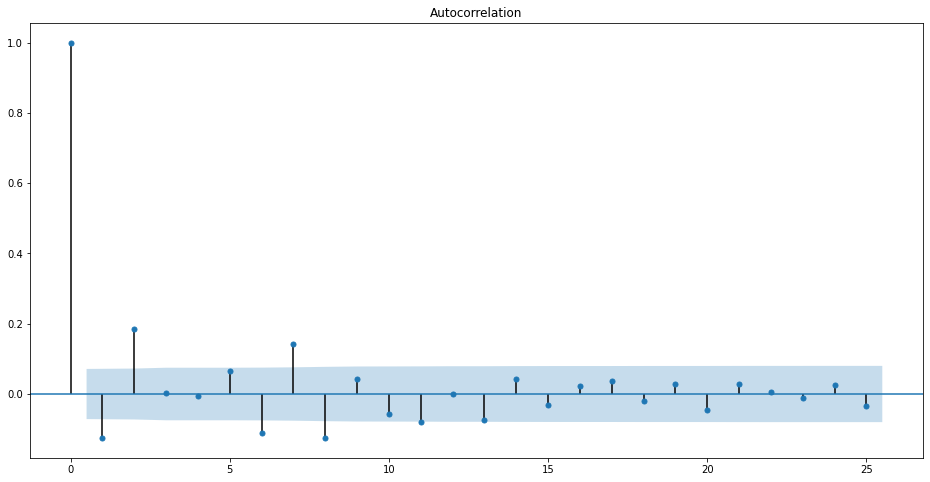

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(16,8))
fig = plot_acf(df_2['log_rtns'].values.squeeze(), lags=25)

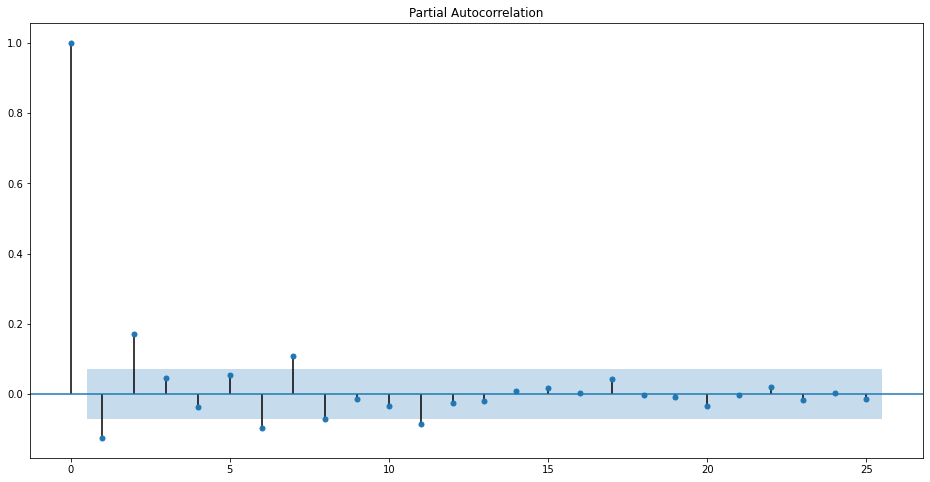

In [ ]:
fig = plot_pacf(df_2['log_rtns'].values.squeeze(), lags=25)

Проводим оценку нормальности нашего распределения доходностей. 

Гистограмма и график квантиль-квантиль показывают наличие тяжелых хвостов, которые говорят о том, что наше распределение больше похоже на распределение Стьюдента, чем на нормальное.

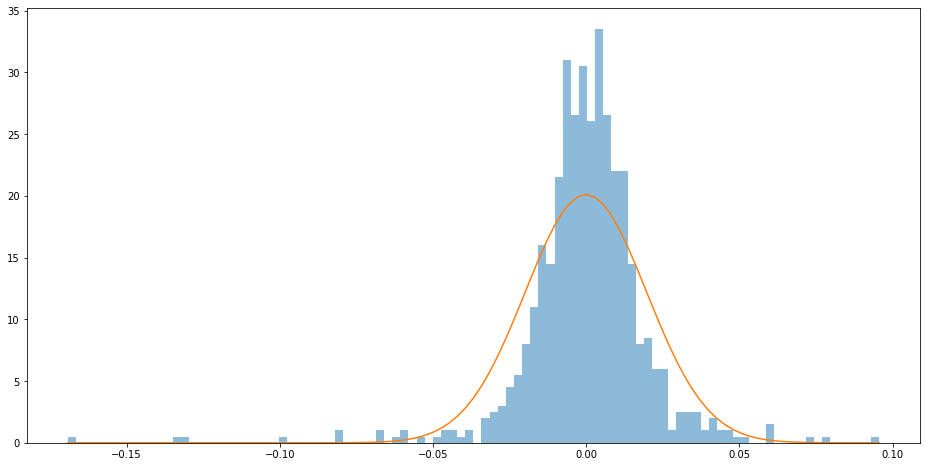

In [ ]:
from scipy.stats import norm
import scipy

# Fit a normal distribution to the data:
mu, sigma = norm.fit(df_2['log_rtns'].values)

ig = plt.figure(figsize=(16,8))
_, bins, _ = plt.hist(df_2['log_rtns'].values, 100, density=1, alpha=0.5)

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

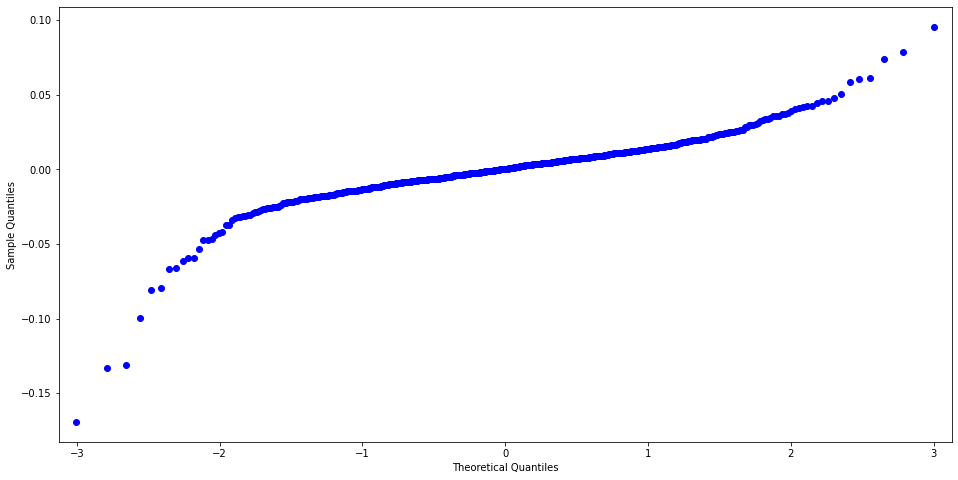

In [ ]:
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

fig = sm.qqplot(df_2['log_rtns'].values)

Проводим тест Дики-Фуллера для проверки стационарности данных.

По результатам теста критическое значение равно 0, следовательно данные стационарны.

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adfuller_summary(X):
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))

adfuller_summary(df_2['log_rtns'])

ADF Statistic: -9.122110
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

Перед построением модели проводим перебор различных комбинаций параметров AR и MA, чтобы вывести модель с наименьшем значением информационного критерия Акаике

In [ ]:
fit20 =  ARIMA(df_2['log_rtns'], order=(2, 0, 0)).fit()
fit21 = ARIMA(df_2['log_rtns'], order=(2, 0, 1)).fit()
fit30 = ARIMA(df_2['log_rtns'], order=(3, 0, 0)).fit()
fit31 = ARIMA(df_2['log_rtns'], order=(3, 0, 1)).fit()
fit110 = ARIMA(df_2['log_rtns'], order=(11, 0, 0)).fit()
fit111 = ARIMA(df_2['log_rtns'], order=(11, 0, 1)).fit()
fit112 = ARIMA(df_2['log_rtns'], order=(11, 0, 2)).fit()
fit22 = ARIMA(df_2['log_rtns'], order=(2, 0, 2)).fit()
fit32 = ARIMA(df_2['log_rtns'], order=(3, 0, 2)).fit()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

Наименьший инф критерий у модели с параметрами AR = 11 MA = 0, однако использование модели с большим лагом может привести к обучению модели преимущественно на исторических данных, поэтому рациональнее выбрать следующую по величине инф критерия модель, у который лаг будет меньше 11. 

Это модель с параметрами AR = 3 MA = 2

In [ ]:
list_of_models = [fit20, fit21,fit22,fit30,fit31,fit32,fit110,fit111, fit112]
aic = []
for model in list_of_models:
    aic.append(model.aic)
aic

[-3797.216010117976,
 -3796.3005468438378,
 -3794.742235684196,
 -3796.6920740897112,
 -3806.21926523238,
 -3808.9503081902303,
 -3809.4743169761396,
 -3808.060738067057,
 -3806.081779206077]

Посмотрим основную информацию по данной модели. 

В результате анализа видно, что инф критерий достаточно низкий, в коэффициенты модели значимы. 

Далее стоит попробовать оценить качество модели через анализ остатков и проведения out-of-sample теста

In [ ]:
model = fit32
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:               log_rtns   No. Observations:                  754
Model:                     ARMA(3, 2)   Log Likelihood                1911.475
Method:                       css-mle   S.D. of innovations              0.019
Date:                Wed, 05 Oct 2022   AIC                          -3808.950
Time:                        04:43:10   BIC                          -3776.573
Sample:                             0   HQIC                         -3796.478
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -9.961e-05      0.001     -0.139      0.889      -0.002       0.001
ar.L1.log_rtns    -1.4538      0.125    -11.613      0.000      -1.699      -1.208
ar.L2.log_rtns    -0.5658      0.187

По коррелограммам ниже видно, что в остатках отсутсвует автокорреляция. Тест Юнга-Бокса показывает незначимый результат (крит значение выше 0,05)следовательно остатки распределены нормально и являются белым шумом

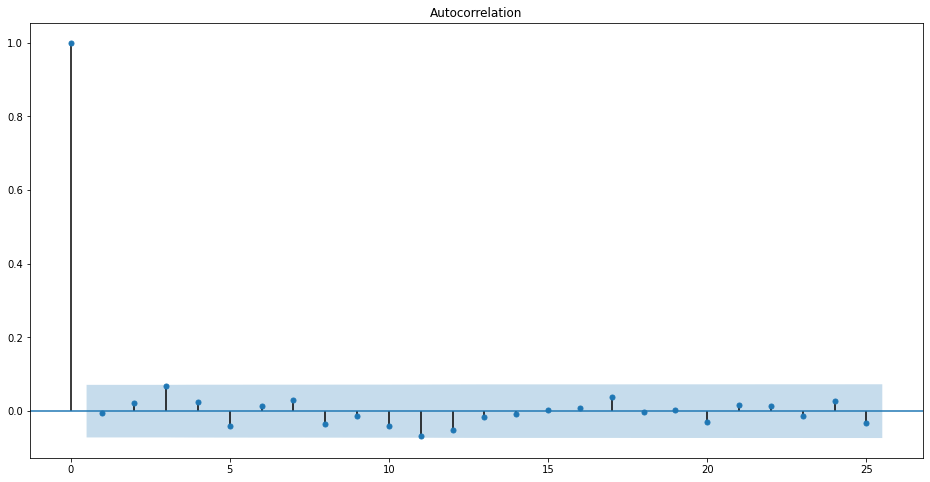

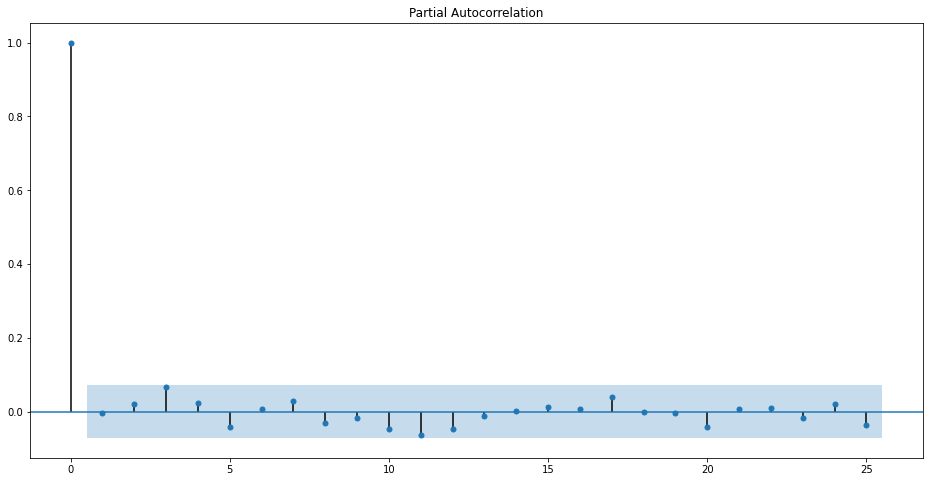

In [ ]:
resid = model.resid
fig = plot_acf(resid, lags = 25) 
fig = plot_pacf(resid, lags = 25)

In [ ]:
import statsmodels.api as sm

test = sm.stats.acorr_ljungbox(resid, lags=[20], boxpierce=True)
print('Ljung-Box test', test[0])
print('p-value', test[1])
print('Box-Pierce', test[2])
print('p-value', test[3])

Ljung-Box test [16.1774319]
p-value [0.70555743]
Box-Pierce [15.94397427]
p-value [0.72009387]


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


Для оценки качества модели также воспользуемся средней абсолютной ошибкой. 

При оценке финансовых данных нам нужно учитывать любую достаточно значимую ошибку, а среднее значение дстаточно чувствительно к выбросам, поэтому мы смотрим именно на абсолютное среднее ошибок нашей модели.

Как видно по итогам расчета, средние абсолютные значения достаточно низкие, что также говорит в пользу качества нашей модели

In [ ]:
predictions = []
for model in list_of_models:
  predictions.append(model.predict())

from sklearn.metrics import mean_absolute_error

error_mae = []
for predict in predictions:
  error_mae.append(mean_absolute_error(df_2['log_rtns'], predict))
error_mae

[0.012823425311104643,
 0.012806533946824857,
 0.012810127981538418,
 0.01280203673568586,
 0.012789883190442723,
 0.012745833941527134,
 0.01270426264041284,
 0.012717199493630317,
 0.01272430047973592]

In [ ]:
error_mae.index(min(error_mae))

6

Ниже предстален график сравнения наших фактических данных, и значений, предсказанных при помощи модели. Видно, что модель плохо справляется с предсказанием наших данных. Сильные скачки данных она достоверно предсказать не может, что в принципе ожидаемо, поскольку точные предсказания финансовых данных с использованием базовых моделей временных рядов сделать невозможно

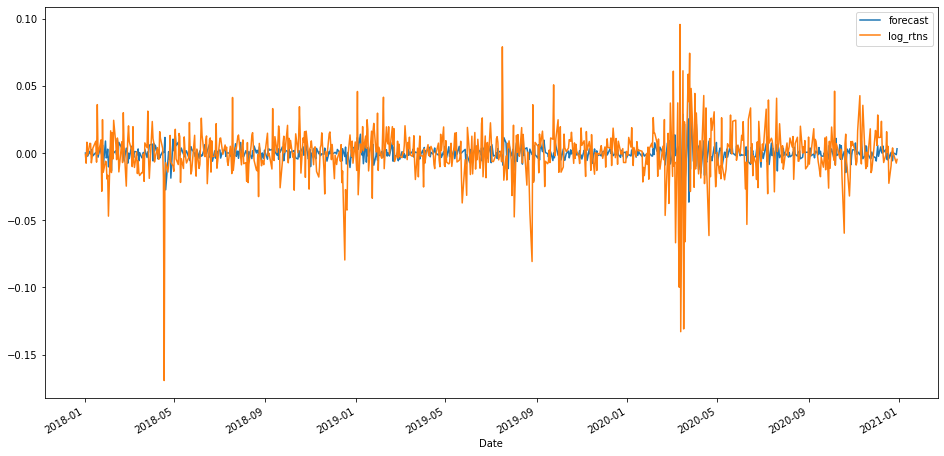

In [ ]:
model.plot_predict(dynamic = False) 
plt.show() 

Теперь проверим прогнозные возможности и качество нашей модели на новых данных. 

Возьмем данные за 2021 год для акций компании Philip Morris

In [ ]:
df_3 = yf.download('PM', start = '2021-01-01', end = '2021-12-31')['Adj Close']
df_4 = pd.DataFrame(df_3)
df_4

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2021-01-04 00:00:00-05:00,74.389168
2021-01-05 00:00:00-05:00,75.201523
2021-01-06 00:00:00-05:00,75.301926
2021-01-07 00:00:00-05:00,75.740044
2021-01-08 00:00:00-05:00,75.840446
...,...
2021-12-23 00:00:00-05:00,89.277977
2021-12-27 00:00:00-05:00,89.863998
2021-12-28 00:00:00-05:00,90.171432


In [ ]:
df_4['log_rtns'] = np.log(df_4.shift(-1)/df_4)
df_4.dropna(inplace = True)

In [ ]:
model302 = ARIMA(df_4['log_rtns'], order=(3, 0, 2)).fit()
model302.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               log_rtns   No. Observations:                  250
Model:                     ARMA(3, 2)   Log Likelihood                 783.379
Method:                       css-mle   S.D. of innovations              0.010
Date:                Wed, 05 Oct 2022   AIC                          -1552.758
Time:                        04:43:13   BIC                          -1528.108
Sample:                             0   HQIC                         -1542.837
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0008      0.001      1.357      0.175      -0.000       0.002
ar.L1.log_rtns     1.1916      0.064     18.709      0.000       1.067       1.316
ar.L2.log_rtns    -0.8682      0.082    -10.637      0.000      -1.028      -0.708
ar.L3.log_rtns    -0.0995      0.063     -1.569      0.117      -0.224       0.025
ma.L1.log_rtns    -1.3114      0.031    -41.924      0.000      -1.373      -1.250
ma.L2.log_rtns     0.9995      0.045     22.124      0.000       0.911       1.088
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6476           -0.7639j            1.0014           -0.1381
AR.2            0.6476           +0.7639j            1.0014            0.1381
AR.3          -10.0165           -0.0000j           10.0165           -0.5000
MA.1            0.6560           -0.7551j            1.0003           -0.1362
MA.2            0.6560           +0.7551j            1.0003            0.1362
-----------------------------------------------------------------------------
"""

Автокорреляции в остатках модели, судя по графикам, нет. Тест на автокорреляцию Юнга-Бокса показывает её отсутвие, поскольку его критическое значение выше 0,05.Средняя абсолютная ошибка также мала





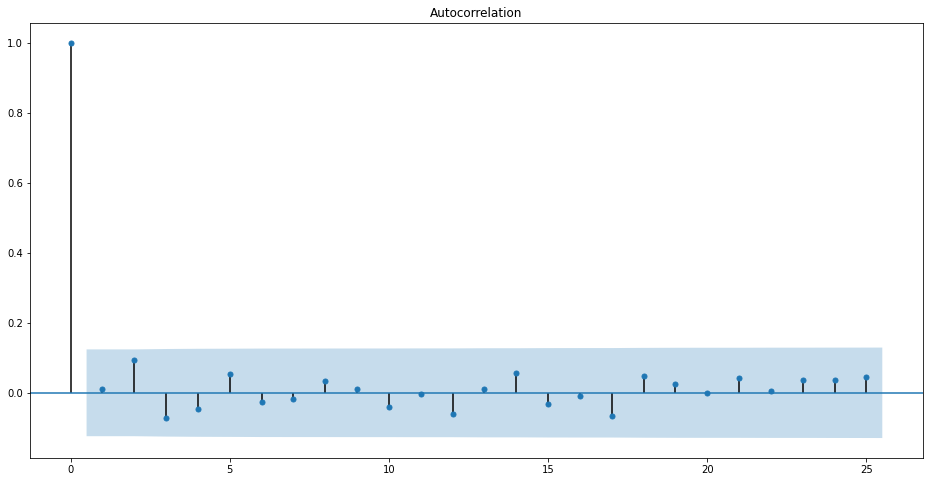

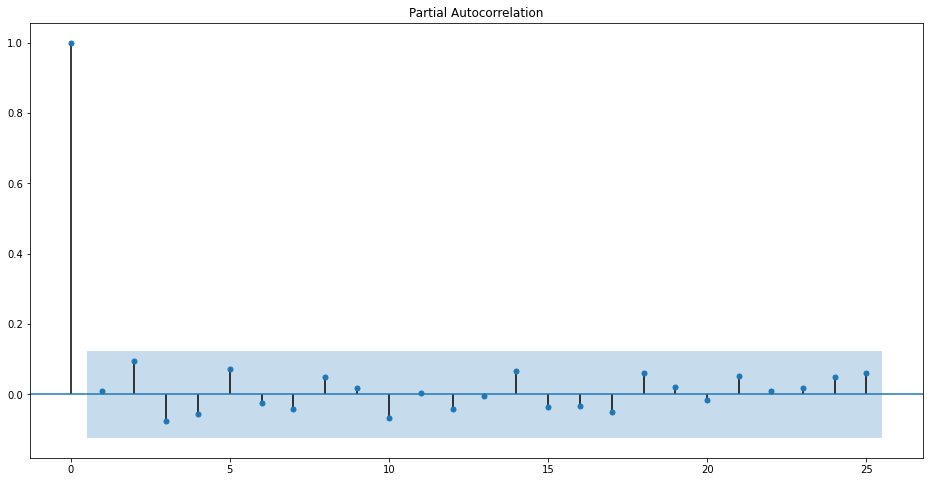

In [ ]:
resid = model302.resid
fig = plot_acf(resid, lags = 25) 
fig = plot_pacf(resid, lags = 25) 

In [ ]:

test = sm.stats.acorr_ljungbox(resid, lags=[20], boxpierce=True)
print('Ljung-Box test', test[0])
print('p-value', test[1])
print('Box-Pierce', test[2])
print('p-value', test[3])

Ljung-Box test [10.12097758]
p-value [0.96592483]
Box-Pierce [9.69833437]
p-value [0.97331792]


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [ ]:
# 0.012745830930486889
predict = model302.predict()
error_mae = mean_absolute_error(df_4['log_rtns'], predict)
error_mae

0.008052437897357547

При оценке прогнозных значений видно, что наша модель, несмотря на хорошие характеристики не справляется с прогнозированием изменения дохдности актива, её значения далеки от реальных

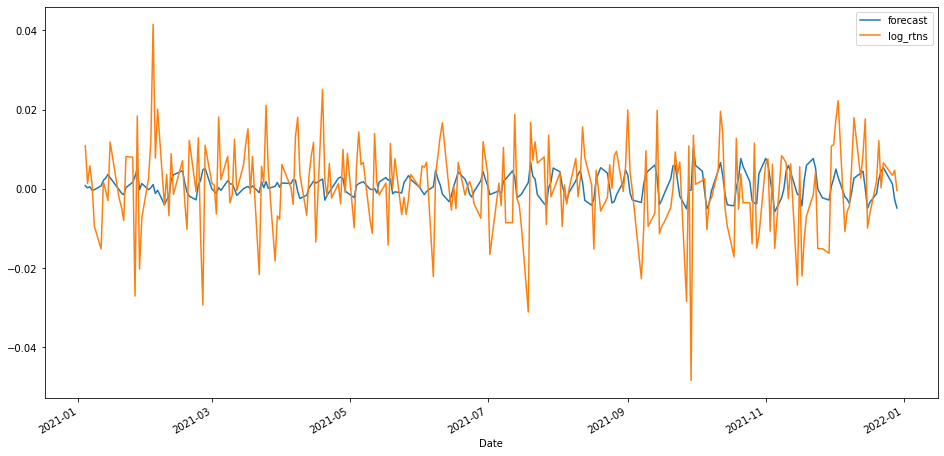

In [ ]:
model302.plot_predict(dynamic = False) 
plt.show() 

Теперь перейдем к анализу дисперсии нашего временного ряда во времени. 

Прогнозировать волатильность будем с использованием GARCH модели. Целесообразность использования данной модели заключается в том, что финансовые данные имееют нестабильную дисперсию во времени: она то больше, то меньше. Данный феномен хорошо виден на графиках лог доходности нашего актива. 

In [ ]:
! pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 5.3 MB/s 


Для построения модели в качестве её основы берутся остатки от ARMA, которые далее используются в GARCH

Оценка автокорреляции остатков проводится при возведении их значений в квадрат. Как видно ниже, автокорреляция в квадратах остатков присутсвует. 

Дополнительно ниже проводится тест Юнга-Бокса на наличие автокорреляции в остатаках. Как видно из результатов теста: критическое значение близко к 0, следовательно автокорреляция присутвует.

Наши данные походят для построения GARCH модели

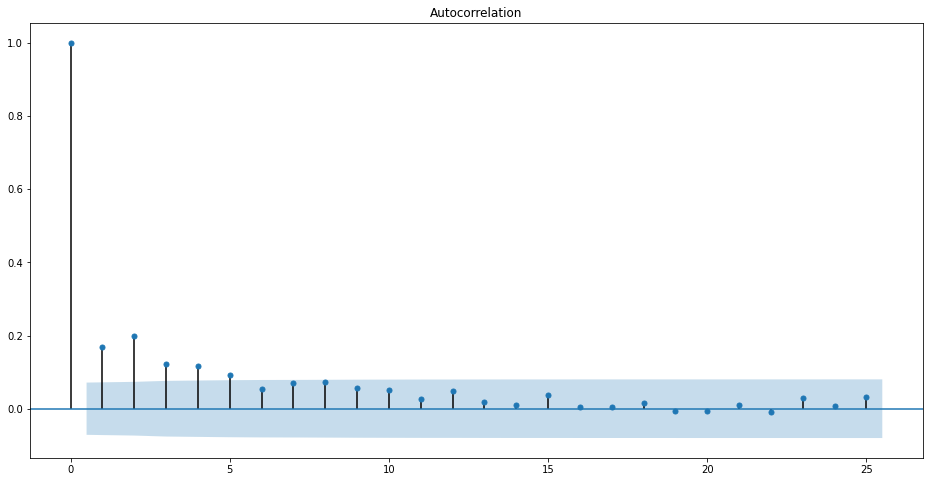

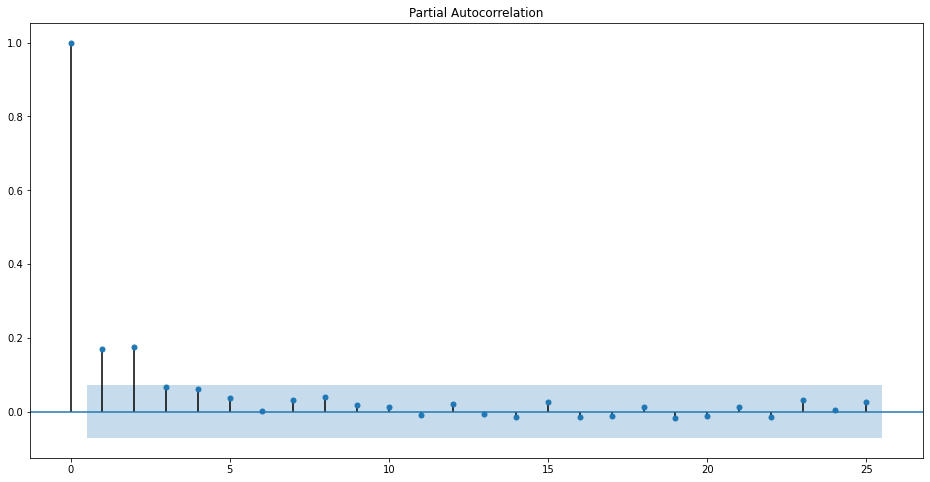

In [ ]:
resid = fit32.resid
y = resid - 0
y_sq = y**2
fig = plot_acf(y_sq, lags = 25) 
fig = plot_pacf(y_sq, lags = 25) 

In [ ]:
import statsmodels.api as sm

test = sm.stats.acorr_ljungbox(y_sq, lags=[20], boxpierce=True)
print('Ljung-Box test', test[0])
print('p-value', test[1])
print('Box-Pierce', test[2])
print('p-value', test[3])

Ljung-Box test [98.04370886]
p-value [2.81590481e-12]
Box-Pierce [97.31012557]
p-value [3.80411736e-12]


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [ ]:
from arch import arch_model

После анализа корролелограмм было выявлено наличие значимых лагов 2 у част автокорр и 4 у автокорр. Следовательно далее проводим перебор моделей с учетом значений данных лагов

In [ ]:
resid = fit32.resid

arch11 = arch_model(resid * 100, vol='Garch', p=1, o=0, q=1, dist='Normal').fit()
arch21 = arch_model(resid * 100, vol='Garch', p=2, o=0, q=1, dist='Normal').fit()
arch12 = arch_model(resid * 100, vol='Garch', p=1, o=0, q=2, dist='Normal').fit()
arch22 = arch_model(resid * 100, vol='Garch', p=2, o=0, q=2, dist='Normal').fit()
arch13 = arch_model(resid * 100, vol='Garch', p=1, o=0, q=3, dist='Normal').fit()
arch23 = arch_model(resid * 100, vol='Garch', p=2, o=0, q=3, dist='Normal').fit()
arch14 = arch_model(resid * 100, vol='Garch', p=1, o=0, q=4, dist='Normal').fit()
arch24 = arch_model(resid * 100, vol='Garch', p=2, o=0, q=4, dist='Normal').fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3979.348302581178
Iteration:      2,   Func. Count:     14,   Neg. LLF: 84323.8607136283
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1496.1056067669374
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1491.2433412460223
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1961.0143386763189
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1491.9700543568679
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1472.3195368876584
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1472.0924492882214
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1472.0855109822544
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1472.0719084986715
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1472.071243835976
Iteration:     12,   Func. Count:     69,   Neg. LLF: 1472.0710974171106
Iteration:     13,   Func. Count:     74,   Neg. LLF: 1472.0710909680033
Iteration:     14,   Func. Count:     78,   Neg. LLF: 1

In [ ]:
list_of_models = [arch11, arch21, arch12, arch22, arch13, arch23, arch14, arch24]

Наименьший критерий Акаике у первой модели, посмотрим её основные показатели

In [ ]:
list_of_aic = []
for i, model in zip(range(len(list_of_models)), list_of_models):
  list_of_aic.append((i, model.aic))
list_of_aic 

[(0, 2952.1421819360066),
 (1, 2954.130698417389),
 (2, 2954.1421818255612),
 (3, 2956.1306984893),
 (4, 2956.142182060981),
 (5, 2958.1857001908747),
 (6, 2958.1421818628605),
 (7, 2960.130698306739)]

Как видно из результатов, критерий Акаике мал, один из коэффициентов модели незначим, а коэффициент детерминации равен 0.

Исходя из результатов можно предварительно сделать вывод, что наша модель плохо либо совсем не объясняет волатильность данных

In [ ]:
garch = arch_model(resid, p=1, q=1)
garch_model = garch.fit()
print(garch_model.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1384536619.7695246
Iteration:      2,   Func. Count:     18,   Neg. LLF: 54657.40462314579
Iteration:      3,   Func. Count:     30,   Neg. LLF: 169802.95480138512
Iteration:      4,   Func. Count:     42,   Neg. LLF: 1059347.346297275
Iteration:      5,   Func. Count:     54,   Neg. LLF: 6388.7739303746
Iteration:      6,   Func. Count:     64,   Neg. LLF: 370083.3597417559
Iteration:      7,   Func. Count:     75,   Neg. LLF: -1984.4208115898305
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1984.4208125895736
            Iterations: 11
            Function evaluations: 75
            Gradient evaluations: 7
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Lik

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


При проверке остатков видно, что по короллелограммам атокорреляция не  наблюдается в них, тест также Юнга-Бокса говорит об отсутсвии значимой автокорреляции в остатках. Качество модели хорошее

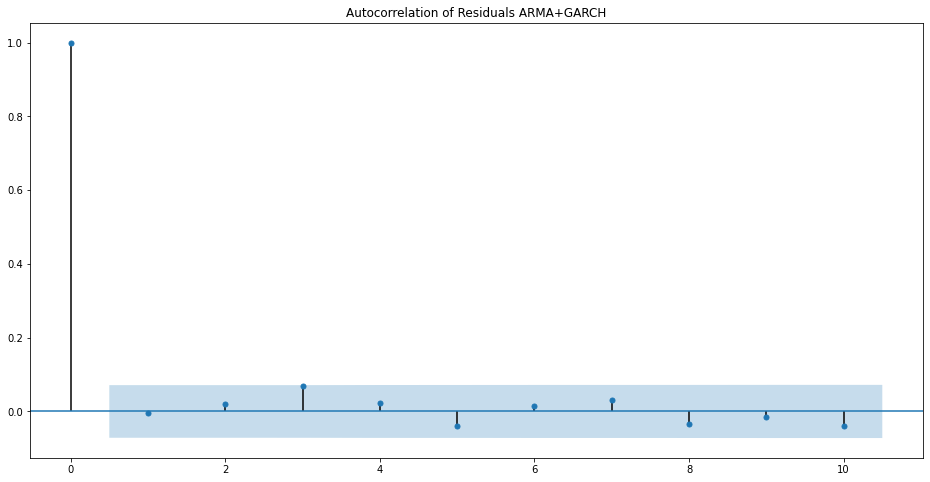

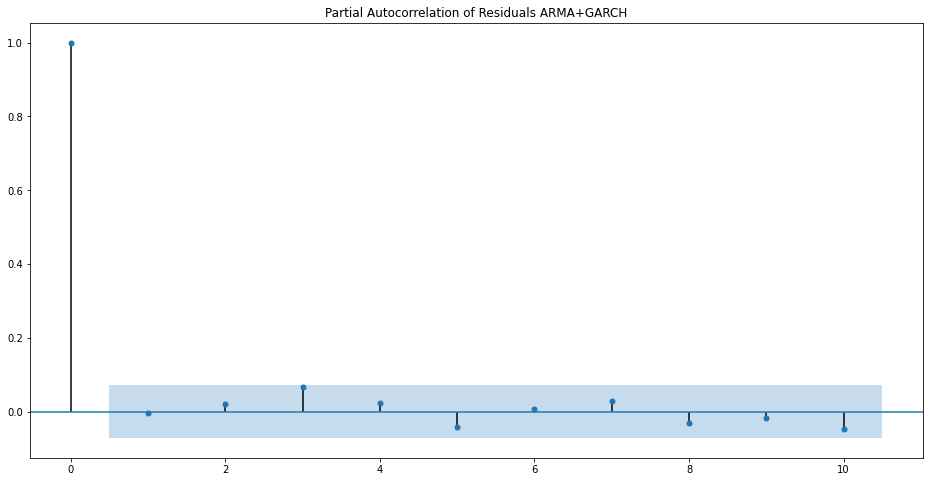

In [ ]:
fig = plot_acf(garch_model.resid.dropna()/100, lags=10)
plt.title('Autocorrelation of Residuals ' + 'ARMA+GARCH')
fig = plot_pacf(garch_model.resid.dropna()/100, lags=10)
plt.title('Partial Autocorrelation of Residuals ARMA+GARCH')
plt.show()

In [ ]:
test = sm.stats.acorr_ljungbox(garch_model.resid, lags=[20], boxpierce=True)
print('Ljung-Box test', test[0])
print('p-value', test[1])
print('Box-Pierce', test[2])
print('p-value', test[3])

Ljung-Box test [16.1774319]
p-value [0.70555743]
Box-Pierce [15.94397427]
p-value [0.72009387]


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [ ]:
import datetime as dt
split_date = dt.datetime(2020,4,1)
res = garch.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1003327937.0548003
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1481.6809454952565
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1481.6809464947273
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003909. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  


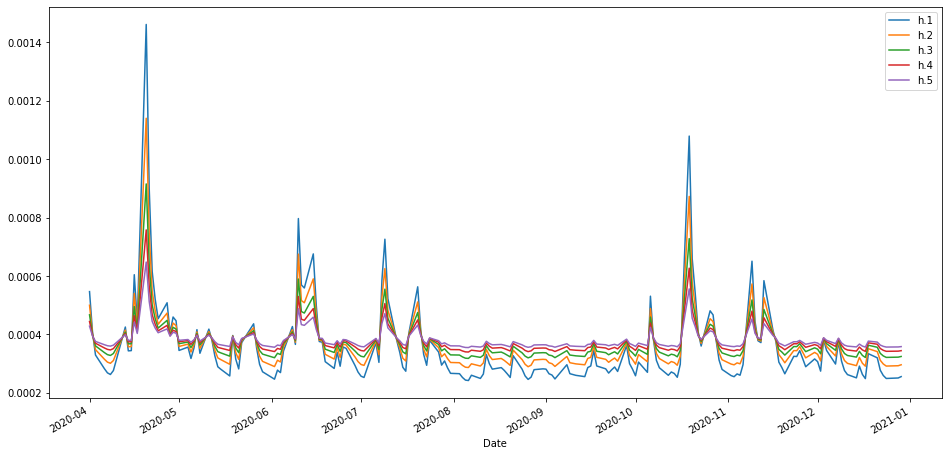

In [ ]:
forecasts = res.forecast(horizon=5, start=split_date)
forecasts.variance[split_date:].plot()

Таким образом, мы построили ARMA и GARCH модели для наших данных. По результатам стоит отметить, что ARMA модель достаточно плохо моделирует наши данные, поскольку они достаточно волатильны и для их точного предсказания подобные модели не подходят. 